# ARIMA Model

### What is an ARIMA model?

**AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**I:** Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**MA:** Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


##### The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.

**d:** The number of times that the raw observations are differenced, also called the degree of differencing.

**q:** The size of the moving average window, also called the order of moving average.

### Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
#from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
import time

### Get Data

In [2]:
data_dir = "/gpfs/gpfs0/project/SDS/instructional/ds5110_sp23_finalproject/"

In [3]:
agg_data = pd.read_csv(data_dir + "aggregate_data.csv", parse_dates=True)
agg_data = agg_data.set_index('date')
agg_data.index = pd.DatetimeIndex(agg_data.index)

In [4]:
agg_data.head()

,close,high,low,open,volume,sma5,sma10,sma15,sma20,ema5,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
date,,,,,,,,,,,,,,,,,,,,,
2015-02-02 10:18:00+05:30,131339.90,131375.10,131302.53,131325.13,609188,131324.612,131343.600,131382.266000,131407.0495,131333.314708,...,4242.451361,5139.981011,4543.348734,4284.915034,-4773.161292,139.259557,75.72,131339.176667,2391.521163,21.041367
2015-02-02 10:19:00+05:30,131303.61,131368.07,131268.38,131342.64,693540,131322.022,131338.209,131365.417333,131399.8400,131323.413139,...,4211.623197,3954.944584,4468.296823,4303.308823,-4942.009553,136.546017,101.27,131313.353333,2370.485111,18.040339
2015-02-02 10:20:00+05:30,131248.36,131321.94,131217.80,131300.96,1610837,131303.796,131328.486,131348.264667,131388.6160,131298.395426,...,3862.393006,2840.307256,3978.410951,4115.856089,-5387.322962,134.329159,105.51,131262.700000,2351.023435,16.246702
2015-02-02 10:21:00+05:30,131257.97,131304.23,131209.05,131243.00,934932,131294.402,131315.095,131336.512000,131378.0600,131284.920284,...,3527.549677,3419.157833,3404.803225,4190.866180,-5136.397490,131.636362,96.63,131257.083333,2328.956512,28.036258
2015-02-02 10:22:00+05:30,131297.42,131329.43,131222.76,131257.06,1012966,131289.452,131307.606,131329.189333,131367.3655,131289.086856,...,3783.520863,4982.998418,3747.487836,4378.816472,-4275.330925,129.867336,106.87,131283.203333,2304.101743,23.595730


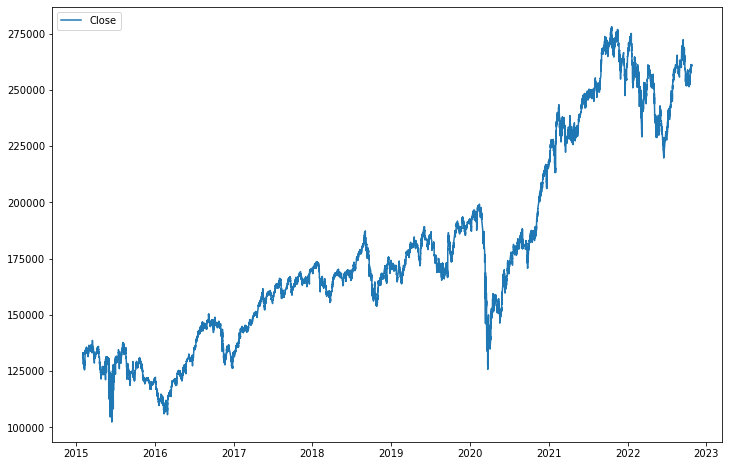

In [5]:
plt.figure(figsize=(12,8))
plt.plot(agg_data.index, agg_data.close, label="Close")
plt.legend(loc="upper left")
plt.show()

## ARIMA

### Monthly

In [6]:
agg_data_monthly = pd.read_csv(data_dir + "aggregate_data_daily.csv", parse_dates=True)
agg_data_monthly['date'] = pd.to_datetime(agg_data_monthly.date).dt.strftime("%Y-%m")
agg_data_monthly.sort_values(by='date',ascending=False)
agg_data_monthly = agg_data_monthly.groupby(["date"]).mean()
agg_data_monthly.index = pd.DatetimeIndex(agg_data_monthly.index)

In [10]:
train_len_monthly = int(len(agg_data_monthly)*0.8)

train_monthly = agg_data_monthly.close[:train_len_monthly]
test_monthly = agg_data_monthly.close[train_len_monthly:]
train_monthly.index = pd.DatetimeIndex(train_monthly.index).to_period('M')
test_monthly.index = pd.DatetimeIndex(test_monthly.index).to_period('M')

In [11]:
modelauto = auto_arima(train_monthly, trace=True, suppress_warnings=True, seasonality = True)
modelauto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1520.351, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1514.448, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1515.544, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1515.397, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1514.877, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1517.135, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.231 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -755.224
Date:                Sun, 23 Apr 2023   AIC                           1514.448
Time:                        08:42:41   BIC                           1519.029
Sample:                    02-28-2015   HQIC                          1516.273
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1383.1012   1140.031      1.213      0.225    -851.318    3617.520
sigma2      5.669e+07   5.19e+06     10.927      0.000    4.65e+07    6.69e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.77   Jarque-Bera (JB):               297.12
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.85   Skew:                            -2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

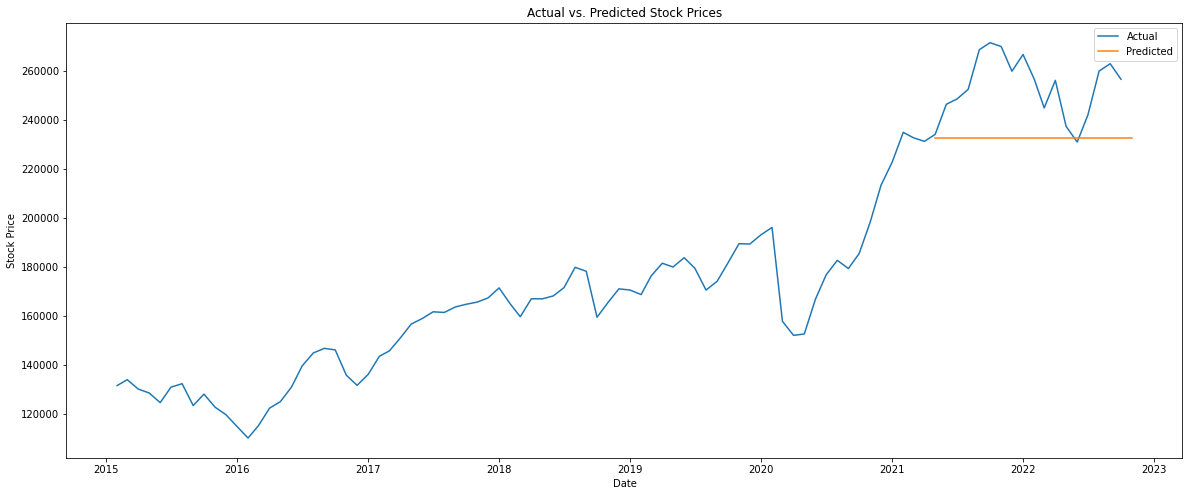

In [12]:
model_monthly = ARIMA(train_monthly, order=(0,1,0)) 
model_monthly = model_monthly.fit()

pred_monthly = model_monthly.predict(start=train_len_monthly, end = len(agg_data_monthly)-1, typ='levels')

# Visualize predictions and actual stock prices
plt.figure(figsize=(20,8))
plt.plot(agg_data_monthly.close, label='Actual')
plt.plot(test_monthly.index, pred_monthly, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [13]:
mse_monthly = mean_squared_error(test_monthly, pred_monthly)
mse_monthly

550611456.5081987

### Daily

In [14]:
agg_data_daily = pd.read_csv(data_dir + "aggregate_data_daily.csv", parse_dates=True)
agg_data_daily = agg_data_daily.set_index('date')
agg_data_daily.index = pd.DatetimeIndex(agg_data_daily.index)

In [15]:
train_len_daily = int(len(agg_data_daily)*0.8)

train_daily = agg_data_daily.close[:train_len_daily]
test_daily = agg_data_daily.close[train_len_daily:]
train_daily.index = pd.DatetimeIndex(train_daily.index).to_period('D')
test_daily.index = pd.DatetimeIndex(test_daily.index).to_period('D')

In [16]:
modelauto_daily = auto_arima(train_daily, trace=True, suppress_warnings=True, seasonality = True)
modelauto_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24970.957, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24976.517, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24963.162, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24963.082, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24977.416, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24965.223, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24965.192, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24967.182, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=24963.428, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.475 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1415
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -12478.541
Date:                Sun, 23 Apr 2023   AIC                          24963.082
Time:                        08:42:50   BIC                          24978.844
Sample:                    02-02-2015   HQIC                         24968.971
                         - 04-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     66.1150     46.319      1.427      0.153     -24.668     156.898
ma.L1          0.0576      0.005     10.853      0.000       0.047       0.068
sigma2      2.662e+06   4.31e+04     61.760      0.000    2.58e+06    2.75e+06
===================================================================================
Ljung-Box (L1) (Q):                  21.88   Jarque-Bera (JB):              4633.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

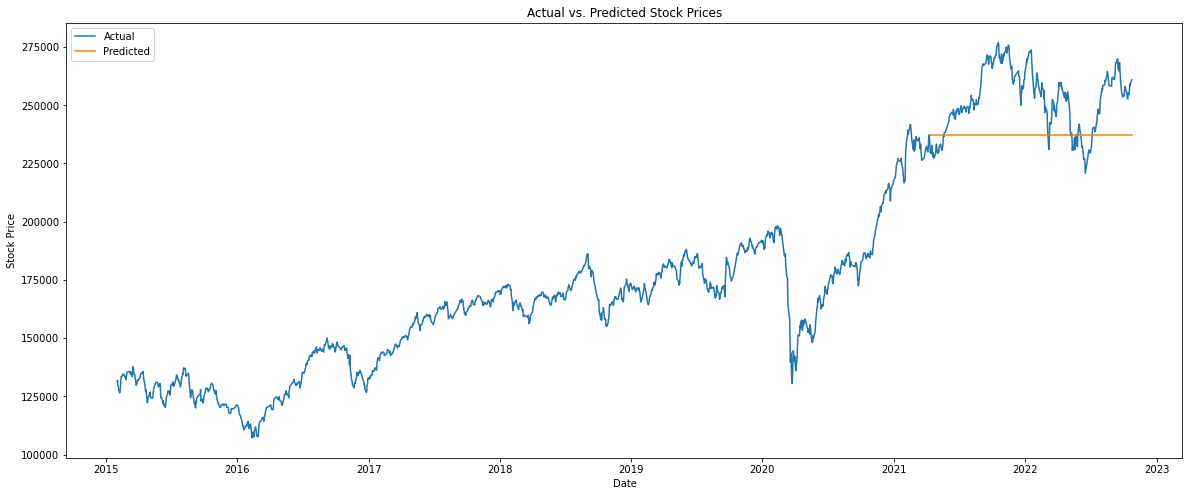

In [18]:
model_daily = ARIMA(train_daily, order=(0,1,1)) 
model_daily = model_daily.fit()

pred_daily = model_daily.predict(start=train_len_daily, end = len(agg_data_daily)-1, typ='levels')

# Visualize predictions and actual stock prices
plt.figure(figsize=(20,8))
plt.plot(agg_data_daily.close, label='Actual')
plt.plot(test_daily.index, pred_daily, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [19]:
mse_daily = mean_squared_error(test_daily, pred_daily)
mse_daily

411872559.2339

### Hourly

In [20]:
agg_data_hourly = pd.read_csv(data_dir + "aggregate_data_hourly.csv", parse_dates=True)
agg_data_hourly = agg_data_hourly.set_index('date')
agg_data_hourly.index = pd.DatetimeIndex(agg_data_hourly.index)

In [21]:
train_len_hourly = int(len(agg_data_hourly)*0.8)

train_hourly = agg_data_hourly.close[:train_len_hourly]
test_hourly = agg_data_hourly.close[train_len_hourly:]
train_hourly.index = pd.DatetimeIndex(train_hourly.index).to_period('D')
test_hourly.index = pd.DatetimeIndex(test_hourly.index).to_period('D')

In [22]:
modelauto_hourly = auto_arima(train_hourly, trace=True, suppress_warnings=True, seasonality = True)
modelauto_hourly.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=154592.885, Time=3.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=154675.730, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154598.834, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154603.567, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154676.756, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=154590.807, Time=1.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=154589.548, Time=0.67 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=154589.879, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154590.710, Time=1.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=154592.967, Time=1.17 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=154589.811, Time=0.30 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 10.372 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 9872
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -77290.774
Date:                Sun, 23 Apr 2023   AIC                         154589.548
Time:                        08:43:19   BIC                         154618.337
Sample:                    02-02-2015   HQIC                        154599.299
                         - 04-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.0896      7.063      1.287      0.198      -4.753      22.932
ma.L1          0.0730      0.002     33.791      0.000       0.069       0.077
ma.L2          0.0359      0.003     10.316      0.000       0.029       0.043
sigma2      3.691e+05    941.319    392.101      0.000    3.67e+05    3.71e+05
===================================================================================
Ljung-Box (L1) (Q):                   7.43   Jarque-Bera (JB):           2163184.73
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                            -2.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        75.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

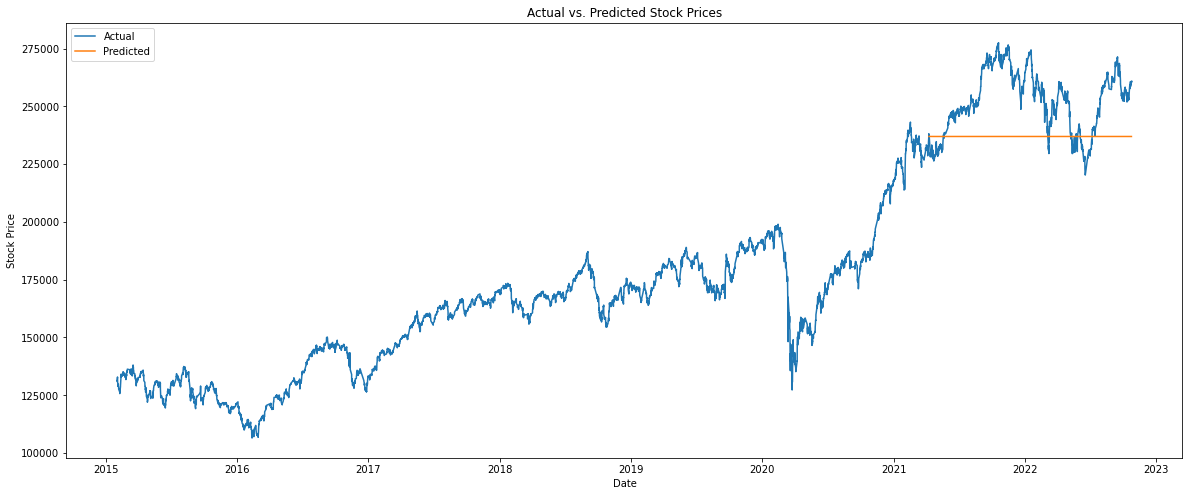

In [24]:
model_hourly = ARIMA(train_hourly, order=(0,1,2)) 
model_hourly = model_hourly.fit()

pred_hourly = model_hourly.predict(start=train_len_hourly, end = len(agg_data_hourly)-1, typ='levels')

# Visualize predictions and actual stock prices
plt.figure(figsize=(20,8))
plt.plot(agg_data_hourly.close, label='Actual')
plt.plot(test_hourly.index, pred_hourly, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.show()

In [25]:
mse_hourly = mean_squared_error(test_hourly, pred_hourly)
mse_hourly

419411242.90217763

## Comparison

<AxesSubplot:xlabel='Model'>

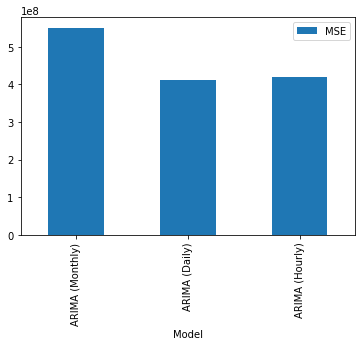

In [27]:
mse = pd.DataFrame({'Model' : ['ARIMA (Monthly)', 'ARIMA (Daily)', 'ARIMA (Hourly)'],
                   'MSE' : [mse_monthly, mse_daily, mse_hourly]}).set_index('Model')
mse.plot.bar()